In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

In [2]:
task_label = 'tonecat'

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
#bidsroot = os.path.join(project_dir,'data_bids')
bidsroot = os.path.join(project_dir,'data_bids_noIntendedFor')
deriv_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [3]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT01', 'sub-FLT16',  
               'sub-FLT19', 'sub-FLT20',
               'sub-FLT25', 'sub-FLT26',
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [4]:
print(participants_df)

   participant_id  age sex         group
0       sub-FLT02   21   F  non-Mandarin
1       sub-FLT03   25   F      Mandarin
2       sub-FLT04   21   F  non-Mandarin
3       sub-FLT05   26   M      Mandarin
4       sub-FLT06   21   F  non-Mandarin
5       sub-FLT07   22   M      Mandarin
6       sub-FLT08   23   F      Mandarin
7       sub-FLT09   30   F  non-Mandarin
8       sub-FLT10   23   F      Mandarin
9       sub-FLT11   20   F  non-Mandarin
10      sub-FLT12   20   F  non-Mandarin
11      sub-FLT13   23   F  non-Mandarin
12      sub-FLT14   23   M  non-Mandarin
13      sub-FLT15   22   M      Mandarin
14      sub-FLT17   29   F      Mandarin
15      sub-FLT18   24   M      Mandarin
16      sub-FLT21   21   M      Mandarin
17      sub-FLT24   20   M      Mandarin


In [5]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [6]:
print(sub_list_mand)

['sub-FLT03', 'sub-FLT05', 'sub-FLT07', 'sub-FLT08', 'sub-FLT10', 'sub-FLT15', 'sub-FLT17', 'sub-FLT18', 'sub-FLT21', 'sub-FLT24']


In [7]:
print(sub_list_nman)

['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14']


#### Create design matrixes

In [5]:
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )

design_mat['Mand'].loc[design_mat['Mand'] == 'Mandarin'] = 1
design_mat['Mand'].loc[design_mat['Mand'] == 'non-Mandarin'] = 0
design_mat['NMan'].loc[design_mat['NMan'] == 'Mandarin'] = 0
design_mat['NMan'].loc[design_mat['NMan'] == 'non-Mandarin'] = 1
design_mat = design_mat.astype('int')
print(design_mat)

    Mand  NMan
0      0     1
1      1     0
2      0     1
3      1     0
4      0     1
5      1     0
6      1     0
7      0     1
8      1     0
9      0     1
10     0     1
11     0     1
12     0     1
13     1     0
14     1     0
15     1     0
16     1     0
17     1     0


#### Design matrix including runs

In [26]:
# 6 runs, mean-centered to 0
run_evs = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]

In [28]:
# as an intermediate step, add list of run EVs to each row
design_mat['run'] = run_evs * len(design_mat)

In [34]:
# and then "explode" the `run` column
design_mat_run = design_mat.explode('run')

In [35]:
design_mat_run

,Mand,NMan,run
0,0,1,-2.5
0,0,1,-1.5
0,0,1,-0.5
0,0,1,0.5
0,0,1,1.5
...,...,...,...
17,1,0,-1.5
17,1,0,-0.5
17,1,0,0.5
17,1,0,1.5


### Get files

In [21]:
contrast_label = 'sound'
fwhm = 4.5
space_label = 'MNI152NLin2009cAsym'
l1_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l1_fnames = sorted(glob(l1_dir+'/sub-*_space-%s/per_run/run*/'%(space_label)
                        +'*%s_map-beta.nii.gz'%(contrast_label)))


In [46]:
#run_id = '05'
l1_fnames_perrun = sorted(glob(l1_dir+'/*space-{}/per_run/run*/*{}_map-beta.nii.gz'.format(space_label, contrast_label)))


### Mandarin-speaking group:

#### Using run GLM

In [48]:
second_level_model = SecondLevelModel().fit(l1_fnames_perrun, design_matrix=design_mat_run)

In [54]:
# WIP – what's the correct contrast??
z_map = second_level_model.compute_contrast(second_level_contrast=[1, -1, 0], 
                                            second_level_stat_type='F',
                                            output_type='z_score')

ValueError: object arrays are not supported

In [ ]:
from nilearn.image import threshold_img
threshold = 1.96 # 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    #cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
plotting.view_img(z_map, 
                  threshold=2, 
                  cut_coords=[17,12,5],
                  title='Non-Mand sound > baseline')

#### Using combined GLM, with contrast isolating Mandarin group

In [9]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

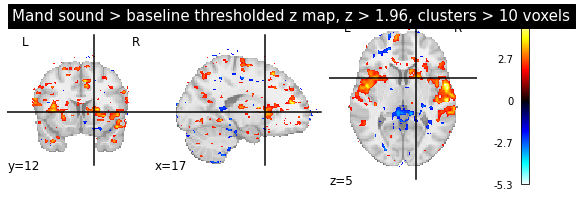

In [12]:
from nilearn.image import threshold_img
threshold = 1.96 # 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    #cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

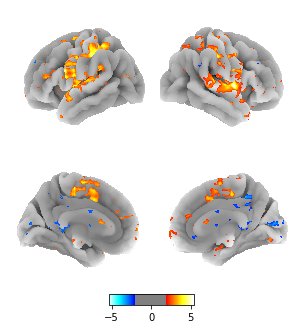

In [13]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          colorbar=True)
plotting.show()

### Non-Mandarin speaking group:

#### Using combined GLM, with contrast isolating non-Mandarin-speaking group

In [14]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[0, 1], output_type='z_score')

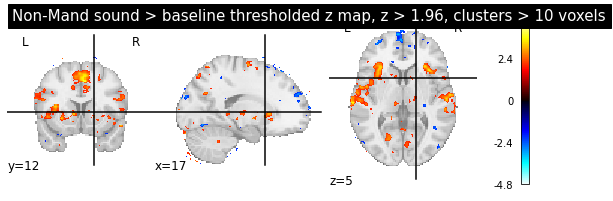

In [15]:
from nilearn.image import threshold_img
threshold = 1.96 # 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    #cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

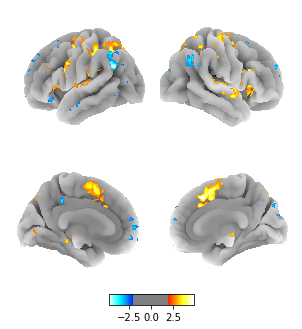

In [16]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          colorbar=True)
plotting.show()

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



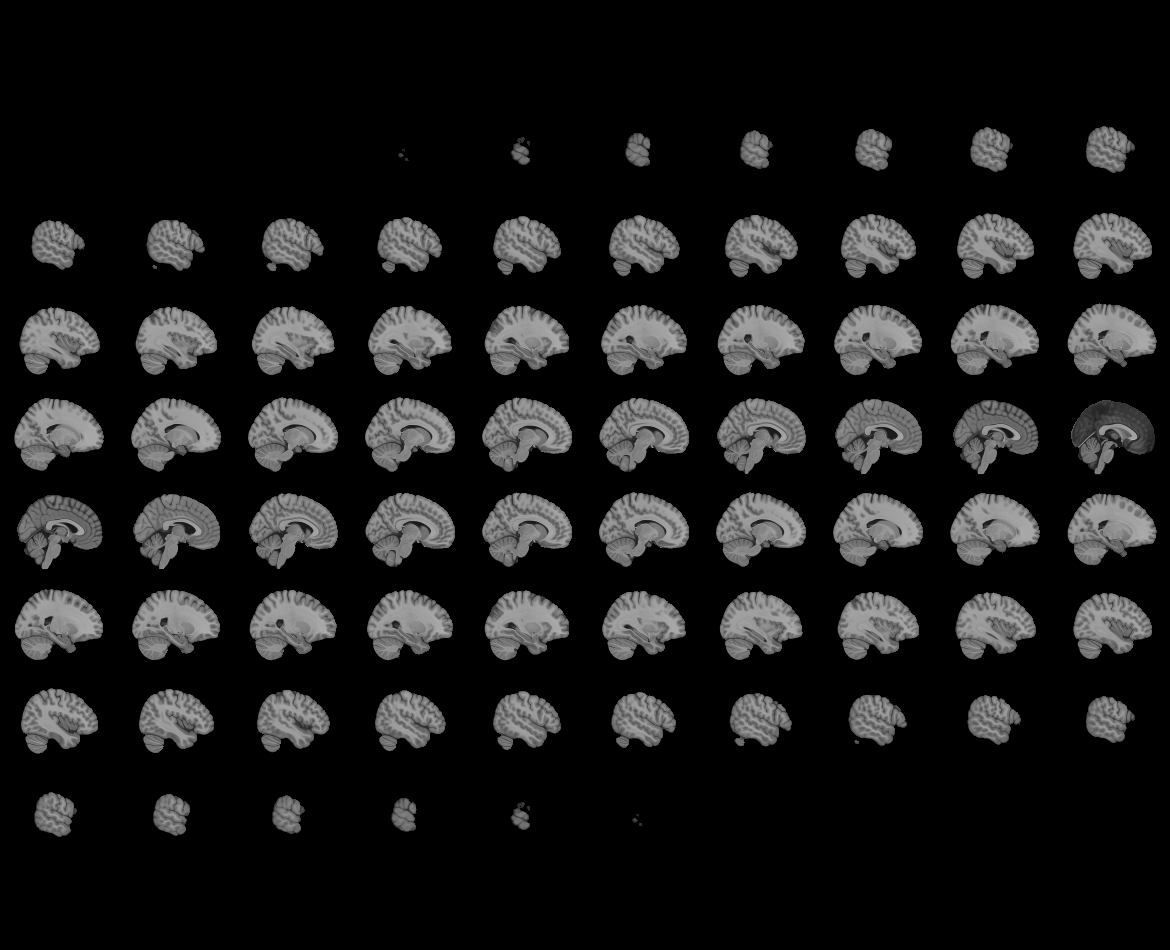
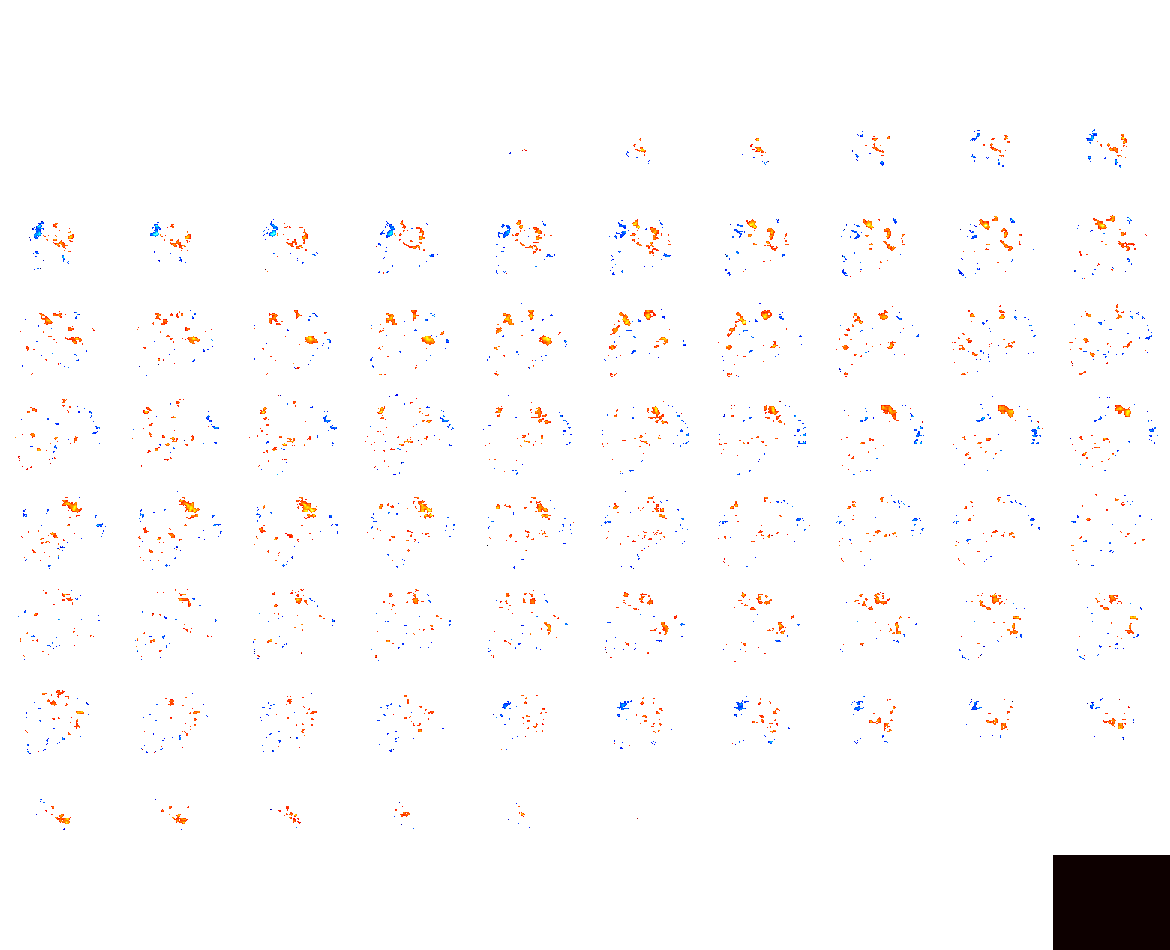

In [19]:
plotting.view_img(z_map, 
                  threshold=2, 
                  cut_coords=[17,12,5],
                  title='Non-Mand sound > baseline')

### Group differences

In [24]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[1, -1], output_type='z_score')

In [ ]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

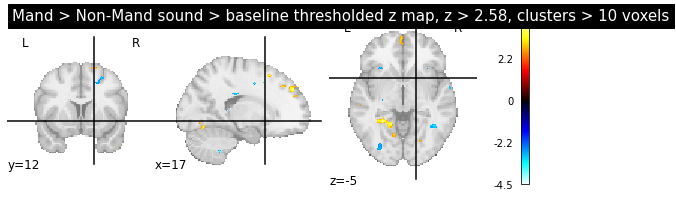

In [21]:
plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,-5], 
    title='Mand > Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

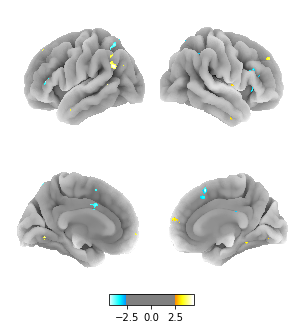

In [22]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          colorbar=True)
plotting.show()

#### And try the reverse, just to confirm they are equal but opposite....

In [59]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

#z_map = second_level_model.compute_contrast(second_level_contrast='group', output_type='z_score')
z_map = second_level_model.compute_contrast(second_level_contrast=[-1, 1], output_type='z_score')

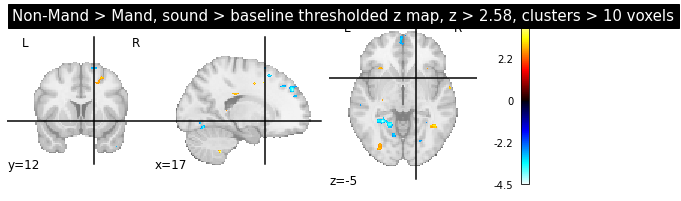

In [60]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)
plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,-5], 
    title='Non-Mand > Mand, %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

### Permutation tests

In [43]:
from nilearn.glm.second_level import non_parametric_inference

In [ ]:
contrast_map_filenames = 

In [ ]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(contrast_map_filenames,
                             design_matrix=design_mat_groupdiff,
                             n_perm=1000,
                             n_jobs=1)

### All participants

In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames, design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map - %s > baseline'%contrast_label)

In [ ]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='%s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn.glm import threshold_stats_img
fpr_alpha = .01
cthresh = 10
thresholded_map1, \
    threshold1 = threshold_stats_img(
                                    z_map,
                                    alpha=fpr_alpha,
                                    height_control='fpr',
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                    )
plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='%s > baseline thresholded z map, fpr <%.03f, clusters > %d voxels'%(contrast_label, fpr_alpha, cthresh))
print(threshold1)

In [ ]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='%s > baseline thresholded z map, expected fdr = .05'%contrast_label,
                       threshold=threshold2)

### Surface plots

In [114]:
from nilearn import datasets, surface

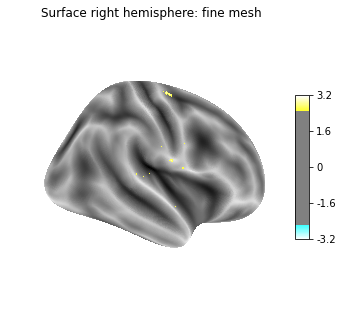

In [115]:
big_fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
big_texture = surface.vol_to_surf(z_map, big_fsaverage.pial_right)

plotting.plot_surf_stat_map(big_fsaverage.infl_right,
                            big_texture, hemi='right', colorbar=True,
                            title='Surface right hemisphere: fine mesh',
                            threshold=2.58, bg_map=big_fsaverage.sulc_right)
plotting.show()

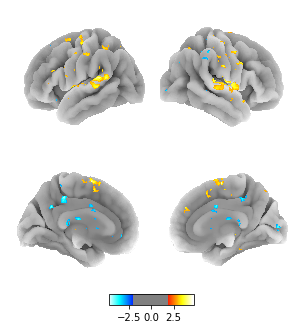

In [119]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1.96, #2.58,
                          colorbar=True)
plotting.show()

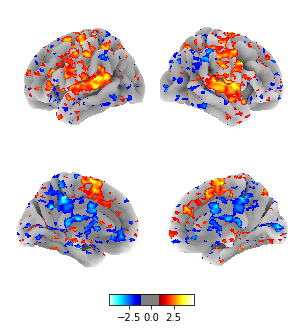

In [117]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1, #2.58,
                          colorbar=True)
plotting.show()